# TP Coding a GAN in tensorflow/keras

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [2]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [3]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## GAN parameters

In [4]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [5]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    # START TO FILL IN
    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2)
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels * self.n_channels)
    # END TO FILL IN

  def forward(self, z):
    # START TO FILL IN
    y = self.fc1(z)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc2(y)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc3(y)
    y = torch.tanh(y)
    y = y.view(-1, self.n_channels, self.n_rows, self.n_cols)
    # END TO FILL IN
    
    return(y)


In [6]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    # START TO FILL IN
    self.fc1 = nn.Linear(self.n_pixels * self.n_channels, self.h_dim_2)
    self.fc2 = nn.Linear(self.h_dim_2, self.h_dim_1)
    self.fc3 = nn.Linear(self.h_dim_1, 1)
    # END TO FILL IN

  def forward(self, x):
    y = x.view(-1, self.n_pixels * self.n_channels)
    y = self.fc1(y)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc2(y)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc3(y)
    y = torch.sigmoid(y)  # FILL IN HERE
    return y


Create generator and discriminator 

In [7]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels).to(device) # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_1, h_dim_2, z_dim, n_rows, n_cols, n_channels).to(device) # FILL IN HERE, CAREFUL OF ORDER OF PARAMETERS
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)


## Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [8]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()  # FILL IN CODE

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = -torch.mean(torch.log(d_gen_data))  # FILL IN CODE
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [9]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n_{epochs}-1$
  - For $j=0$ to $n_{iters\_inner}-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```torch.randn``` to create a batch of random Gaussian latent codes:
- ```torch.randn(dim_1, dim_2, dim_3, device=device)```
where ```dim_1, dim_2, dim_3``` are the dimensions of the Tensor.

To create a batch of labels equal to 1, use the following function:
- ```torch.ones(my_shape, dtype=torch.float, device=device)```
where ```my_shape``` is the shape of the tensor of ones that you wish. 

Similarly, to create a batch of zeros, use:
- ```torch.zeros(my_shape, dtype=torch.float, device=device)```

In [10]:
print(device)

cpu


Starting Training
[0/400][0/16] 	Loss_D: 1.3799	Loss_G: 0.6984	D(x): 0.5013	D(G(z)): 0.4979


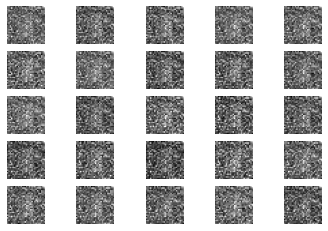

[1/400][0/16] 	Loss_D: 0.9550	Loss_G: 0.6294	D(x): 0.9055	D(G(z)): 0.5745
[2/400][0/16] 	Loss_D: 1.1360	Loss_G: 0.6297	D(x): 0.7878	D(G(z)): 0.5913
[3/400][0/16] 	Loss_D: 1.2910	Loss_G: 0.6533	D(x): 0.6968	D(G(z)): 0.6039
[4/400][0/16] 	Loss_D: 1.3071	Loss_G: 0.7275	D(x): 0.6465	D(G(z)): 0.5791
[5/400][0/16] 	Loss_D: 1.2293	Loss_G: 0.9032	D(x): 0.6862	D(G(z)): 0.5712
[6/400][0/16] 	Loss_D: 1.0389	Loss_G: 1.0876	D(x): 0.7053	D(G(z)): 0.4952
[7/400][0/16] 	Loss_D: 1.0920	Loss_G: 1.0548	D(x): 0.6667	D(G(z)): 0.4909
[8/400][0/16] 	Loss_D: 1.0790	Loss_G: 1.2052	D(x): 0.6769	D(G(z)): 0.4948
[9/400][0/16] 	Loss_D: 1.1713	Loss_G: 1.1120	D(x): 0.6895	D(G(z)): 0.5441
[10/400][0/16] 	Loss_D: 0.9481	Loss_G: 1.2418	D(x): 0.7036	D(G(z)): 0.4464
[11/400][0/16] 	Loss_D: 0.9954	Loss_G: 1.1275	D(x): 0.6513	D(G(z)): 0.4296
[12/400][0/16] 	Loss_D: 1.3257	Loss_G: 0.7535	D(x): 0.5766	D(G(z)): 0.5361
[13/400][0/16] 	Loss_D: 1.3972	Loss_G: 0.7215	D(x): 0.5394	D(G(z)): 0.5362
[14/400][0/16] 	Loss_D: 1.2722	Los

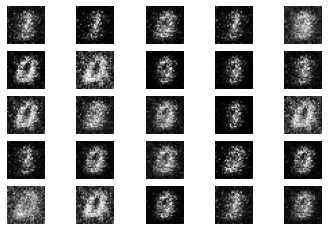

[26/400][0/16] 	Loss_D: 1.2591	Loss_G: 1.4651	D(x): 0.8158	D(G(z)): 0.6325
[27/400][0/16] 	Loss_D: 1.0213	Loss_G: 1.1500	D(x): 0.6416	D(G(z)): 0.4273
[28/400][0/16] 	Loss_D: 1.1594	Loss_G: 0.8842	D(x): 0.5502	D(G(z)): 0.4089
[29/400][0/16] 	Loss_D: 1.0071	Loss_G: 1.4865	D(x): 0.7081	D(G(z)): 0.4682
[30/400][0/16] 	Loss_D: 1.0708	Loss_G: 0.9948	D(x): 0.5325	D(G(z)): 0.3158
[31/400][0/16] 	Loss_D: 0.9216	Loss_G: 1.6884	D(x): 0.7715	D(G(z)): 0.4720
[32/400][0/16] 	Loss_D: 1.1680	Loss_G: 0.9701	D(x): 0.4787	D(G(z)): 0.3036
[33/400][0/16] 	Loss_D: 0.9678	Loss_G: 1.2693	D(x): 0.6902	D(G(z)): 0.4271
[34/400][0/16] 	Loss_D: 1.2362	Loss_G: 1.6636	D(x): 0.7965	D(G(z)): 0.6153
[35/400][0/16] 	Loss_D: 1.0506	Loss_G: 1.0725	D(x): 0.6051	D(G(z)): 0.3934
[36/400][0/16] 	Loss_D: 1.1073	Loss_G: 1.3860	D(x): 0.6356	D(G(z)): 0.4422
[37/400][0/16] 	Loss_D: 1.0392	Loss_G: 0.9075	D(x): 0.5539	D(G(z)): 0.3319
[38/400][0/16] 	Loss_D: 0.9632	Loss_G: 1.0471	D(x): 0.5374	D(G(z)): 0.2477
[39/400][0/16] 	Loss_D: 1

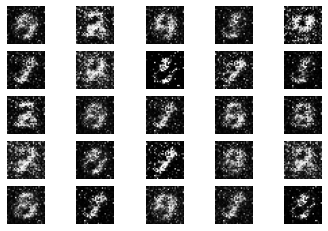

[51/400][0/16] 	Loss_D: 0.8622	Loss_G: 2.3239	D(x): 0.8745	D(G(z)): 0.5022
[52/400][0/16] 	Loss_D: 0.9334	Loss_G: 1.4251	D(x): 0.6434	D(G(z)): 0.3607
[53/400][0/16] 	Loss_D: 1.0418	Loss_G: 1.0901	D(x): 0.4713	D(G(z)): 0.1770
[54/400][0/16] 	Loss_D: 1.3910	Loss_G: 2.5480	D(x): 0.9286	D(G(z)): 0.7099
[55/400][0/16] 	Loss_D: 0.7057	Loss_G: 2.0387	D(x): 0.7585	D(G(z)): 0.3247
[56/400][0/16] 	Loss_D: 0.7472	Loss_G: 1.8382	D(x): 0.7206	D(G(z)): 0.3131
[57/400][0/16] 	Loss_D: 0.6939	Loss_G: 1.6229	D(x): 0.7872	D(G(z)): 0.3282
[58/400][0/16] 	Loss_D: 0.8301	Loss_G: 1.1855	D(x): 0.5882	D(G(z)): 0.1890
[59/400][0/16] 	Loss_D: 0.8573	Loss_G: 2.0471	D(x): 0.8172	D(G(z)): 0.4588
[60/400][0/16] 	Loss_D: 1.0003	Loss_G: 1.0338	D(x): 0.5341	D(G(z)): 0.2172
[61/400][0/16] 	Loss_D: 0.9646	Loss_G: 1.8773	D(x): 0.6748	D(G(z)): 0.4018
[62/400][0/16] 	Loss_D: 1.2216	Loss_G: 2.6586	D(x): 0.9003	D(G(z)): 0.6549
[63/400][0/16] 	Loss_D: 1.4045	Loss_G: 2.5797	D(x): 0.8975	D(G(z)): 0.6927
[64/400][0/16] 	Loss_D: 0

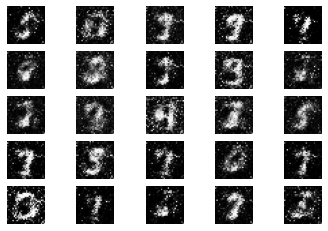

[76/400][0/16] 	Loss_D: 0.8405	Loss_G: 1.5917	D(x): 0.7017	D(G(z)): 0.3617
[77/400][0/16] 	Loss_D: 0.8559	Loss_G: 1.2566	D(x): 0.6375	D(G(z)): 0.2924
[78/400][0/16] 	Loss_D: 0.9825	Loss_G: 0.8852	D(x): 0.5074	D(G(z)): 0.1988
[79/400][0/16] 	Loss_D: 0.9986	Loss_G: 1.0877	D(x): 0.5324	D(G(z)): 0.2171
[80/400][0/16] 	Loss_D: 0.9956	Loss_G: 1.4564	D(x): 0.6891	D(G(z)): 0.4244
[81/400][0/16] 	Loss_D: 0.9168	Loss_G: 1.1080	D(x): 0.5624	D(G(z)): 0.2293
[82/400][0/16] 	Loss_D: 0.9364	Loss_G: 1.7815	D(x): 0.7921	D(G(z)): 0.4826
[83/400][0/16] 	Loss_D: 1.0755	Loss_G: 0.7169	D(x): 0.4715	D(G(z)): 0.1710
[84/400][0/16] 	Loss_D: 1.5759	Loss_G: 0.4529	D(x): 0.2705	D(G(z)): 0.0925
[85/400][0/16] 	Loss_D: 1.0424	Loss_G: 1.9751	D(x): 0.7548	D(G(z)): 0.5115
[86/400][0/16] 	Loss_D: 0.8253	Loss_G: 1.1569	D(x): 0.5909	D(G(z)): 0.2029
[87/400][0/16] 	Loss_D: 0.7997	Loss_G: 1.6268	D(x): 0.7491	D(G(z)): 0.3819
[88/400][0/16] 	Loss_D: 1.0585	Loss_G: 2.2138	D(x): 0.8808	D(G(z)): 0.5808
[89/400][0/16] 	Loss_D: 1

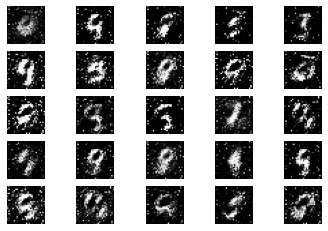

[101/400][0/16] 	Loss_D: 1.0919	Loss_G: 0.8380	D(x): 0.4616	D(G(z)): 0.1231
[102/400][0/16] 	Loss_D: 1.2742	Loss_G: 2.8905	D(x): 0.9034	D(G(z)): 0.6629
[103/400][0/16] 	Loss_D: 0.8273	Loss_G: 2.4132	D(x): 0.8253	D(G(z)): 0.4411
[104/400][0/16] 	Loss_D: 1.0977	Loss_G: 2.6740	D(x): 0.8910	D(G(z)): 0.5932
[105/400][0/16] 	Loss_D: 0.6229	Loss_G: 2.0558	D(x): 0.8472	D(G(z)): 0.3428
[106/400][0/16] 	Loss_D: 0.9357	Loss_G: 1.8682	D(x): 0.7546	D(G(z)): 0.4332
[107/400][0/16] 	Loss_D: 0.9015	Loss_G: 1.3870	D(x): 0.6512	D(G(z)): 0.3244
[108/400][0/16] 	Loss_D: 0.9160	Loss_G: 1.9771	D(x): 0.7482	D(G(z)): 0.4055
[109/400][0/16] 	Loss_D: 0.9853	Loss_G: 2.5893	D(x): 0.8245	D(G(z)): 0.5055
[110/400][0/16] 	Loss_D: 0.7132	Loss_G: 2.1463	D(x): 0.8163	D(G(z)): 0.3751
[111/400][0/16] 	Loss_D: 0.8989	Loss_G: 1.4622	D(x): 0.7140	D(G(z)): 0.3827
[112/400][0/16] 	Loss_D: 0.9227	Loss_G: 2.1729	D(x): 0.7985	D(G(z)): 0.4683
[113/400][0/16] 	Loss_D: 0.9274	Loss_G: 2.0087	D(x): 0.7642	D(G(z)): 0.4380
[114/400][0/

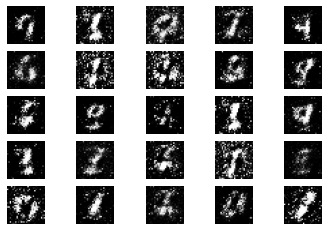

[126/400][0/16] 	Loss_D: 0.8756	Loss_G: 1.5239	D(x): 0.6740	D(G(z)): 0.3043
[127/400][0/16] 	Loss_D: 0.8869	Loss_G: 1.4680	D(x): 0.6414	D(G(z)): 0.2895
[128/400][0/16] 	Loss_D: 0.9800	Loss_G: 2.9239	D(x): 0.8532	D(G(z)): 0.5241
[129/400][0/16] 	Loss_D: 0.7904	Loss_G: 2.3119	D(x): 0.7911	D(G(z)): 0.3862
[130/400][0/16] 	Loss_D: 0.8283	Loss_G: 1.3259	D(x): 0.6574	D(G(z)): 0.2769
[131/400][0/16] 	Loss_D: 0.7673	Loss_G: 1.4347	D(x): 0.7037	D(G(z)): 0.2718
[132/400][0/16] 	Loss_D: 0.8404	Loss_G: 1.4144	D(x): 0.6412	D(G(z)): 0.2249
[133/400][0/16] 	Loss_D: 0.8700	Loss_G: 1.9220	D(x): 0.8081	D(G(z)): 0.4393
[134/400][0/16] 	Loss_D: 0.8390	Loss_G: 1.2948	D(x): 0.6712	D(G(z)): 0.2871
[135/400][0/16] 	Loss_D: 0.8790	Loss_G: 1.1710	D(x): 0.5870	D(G(z)): 0.1587
[136/400][0/16] 	Loss_D: 0.8506	Loss_G: 1.6873	D(x): 0.7536	D(G(z)): 0.3680
[137/400][0/16] 	Loss_D: 0.7117	Loss_G: 1.6283	D(x): 0.7472	D(G(z)): 0.2868
[138/400][0/16] 	Loss_D: 0.8265	Loss_G: 1.0742	D(x): 0.6831	D(G(z)): 0.2928
[139/400][0/

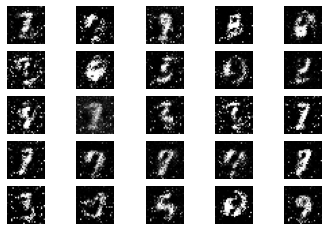

[151/400][0/16] 	Loss_D: 0.9135	Loss_G: 2.0698	D(x): 0.7499	D(G(z)): 0.3856
[152/400][0/16] 	Loss_D: 0.6551	Loss_G: 2.2578	D(x): 0.7885	D(G(z)): 0.2965
[153/400][0/16] 	Loss_D: 0.7487	Loss_G: 1.5237	D(x): 0.6385	D(G(z)): 0.1521
[154/400][0/16] 	Loss_D: 0.7617	Loss_G: 1.6966	D(x): 0.6756	D(G(z)): 0.2276
[155/400][0/16] 	Loss_D: 0.9782	Loss_G: 2.6836	D(x): 0.8521	D(G(z)): 0.5087
[156/400][0/16] 	Loss_D: 1.2668	Loss_G: 0.8243	D(x): 0.4138	D(G(z)): 0.0973
[157/400][0/16] 	Loss_D: 0.8740	Loss_G: 2.2927	D(x): 0.7978	D(G(z)): 0.4121
[158/400][0/16] 	Loss_D: 0.7909	Loss_G: 2.0957	D(x): 0.7617	D(G(z)): 0.3517
[159/400][0/16] 	Loss_D: 0.9748	Loss_G: 1.1748	D(x): 0.5641	D(G(z)): 0.1976
[160/400][0/16] 	Loss_D: 0.9384	Loss_G: 1.2494	D(x): 0.5475	D(G(z)): 0.1396
[161/400][0/16] 	Loss_D: 0.7696	Loss_G: 1.1537	D(x): 0.6650	D(G(z)): 0.2339
[162/400][0/16] 	Loss_D: 0.7687	Loss_G: 1.7551	D(x): 0.7554	D(G(z)): 0.3376
[163/400][0/16] 	Loss_D: 0.7751	Loss_G: 2.4575	D(x): 0.8170	D(G(z)): 0.3990
[164/400][0/

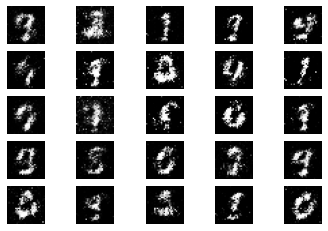

[176/400][0/16] 	Loss_D: 0.6495	Loss_G: 1.6376	D(x): 0.7090	D(G(z)): 0.2044
[177/400][0/16] 	Loss_D: 0.7132	Loss_G: 1.8155	D(x): 0.7279	D(G(z)): 0.2530
[178/400][0/16] 	Loss_D: 1.3223	Loss_G: 0.5326	D(x): 0.3740	D(G(z)): 0.0929
[179/400][0/16] 	Loss_D: 0.9922	Loss_G: 0.9931	D(x): 0.5165	D(G(z)): 0.0950
[180/400][0/16] 	Loss_D: 0.8765	Loss_G: 2.6713	D(x): 0.8223	D(G(z)): 0.4312
[181/400][0/16] 	Loss_D: 1.0804	Loss_G: 1.2098	D(x): 0.4777	D(G(z)): 0.0973
[182/400][0/16] 	Loss_D: 0.7516	Loss_G: 1.5836	D(x): 0.7264	D(G(z)): 0.2942
[183/400][0/16] 	Loss_D: 0.8222	Loss_G: 1.6295	D(x): 0.7610	D(G(z)): 0.3764
[184/400][0/16] 	Loss_D: 1.0591	Loss_G: 0.7364	D(x): 0.5174	D(G(z)): 0.1391
[185/400][0/16] 	Loss_D: 0.8537	Loss_G: 0.7420	D(x): 0.6185	D(G(z)): 0.2190
[186/400][0/16] 	Loss_D: 0.8455	Loss_G: 1.1589	D(x): 0.6033	D(G(z)): 0.1485
[187/400][0/16] 	Loss_D: 1.2102	Loss_G: 3.5177	D(x): 0.9245	D(G(z)): 0.6368
[188/400][0/16] 	Loss_D: 0.7518	Loss_G: 2.2561	D(x): 0.7671	D(G(z)): 0.3318
[189/400][0/

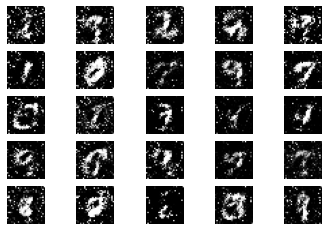

[201/400][0/16] 	Loss_D: 0.7894	Loss_G: 1.7258	D(x): 0.6524	D(G(z)): 0.2037
[202/400][0/16] 	Loss_D: 0.6657	Loss_G: 2.0082	D(x): 0.7751	D(G(z)): 0.2852
[203/400][0/16] 	Loss_D: 0.7622	Loss_G: 1.3984	D(x): 0.7244	D(G(z)): 0.2828
[204/400][0/16] 	Loss_D: 0.9370	Loss_G: 0.9696	D(x): 0.5641	D(G(z)): 0.1462
[205/400][0/16] 	Loss_D: 0.7514	Loss_G: 1.2598	D(x): 0.6383	D(G(z)): 0.1759
[206/400][0/16] 	Loss_D: 0.6955	Loss_G: 2.1162	D(x): 0.7995	D(G(z)): 0.3340
[207/400][0/16] 	Loss_D: 0.7139	Loss_G: 1.6488	D(x): 0.7072	D(G(z)): 0.2247
[208/400][0/16] 	Loss_D: 0.5135	Loss_G: 1.8190	D(x): 0.7545	D(G(z)): 0.1556
[209/400][0/16] 	Loss_D: 0.6747	Loss_G: 1.7649	D(x): 0.7053	D(G(z)): 0.1856
[210/400][0/16] 	Loss_D: 0.6567	Loss_G: 2.2609	D(x): 0.7922	D(G(z)): 0.2966
[211/400][0/16] 	Loss_D: 0.7300	Loss_G: 1.6141	D(x): 0.6942	D(G(z)): 0.2383
[212/400][0/16] 	Loss_D: 0.8443	Loss_G: 2.8658	D(x): 0.8931	D(G(z)): 0.4730
[213/400][0/16] 	Loss_D: 1.0121	Loss_G: 0.8206	D(x): 0.5066	D(G(z)): 0.0806
[214/400][0/

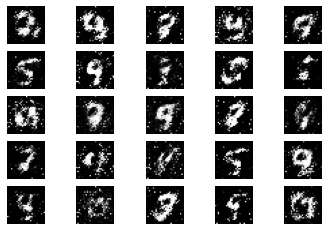

[226/400][0/16] 	Loss_D: 0.6153	Loss_G: 2.3160	D(x): 0.7766	D(G(z)): 0.2350
[227/400][0/16] 	Loss_D: 0.7156	Loss_G: 3.1729	D(x): 0.8734	D(G(z)): 0.3966
[228/400][0/16] 	Loss_D: 0.5680	Loss_G: 1.7270	D(x): 0.7208	D(G(z)): 0.1591
[229/400][0/16] 	Loss_D: 0.6943	Loss_G: 2.5977	D(x): 0.8089	D(G(z)): 0.3304
[230/400][0/16] 	Loss_D: 0.6527	Loss_G: 1.7943	D(x): 0.7986	D(G(z)): 0.2926
[231/400][0/16] 	Loss_D: 0.6443	Loss_G: 1.6241	D(x): 0.6952	D(G(z)): 0.1664
[232/400][0/16] 	Loss_D: 0.8989	Loss_G: 0.7965	D(x): 0.5417	D(G(z)): 0.1185
[233/400][0/16] 	Loss_D: 0.6435	Loss_G: 1.7615	D(x): 0.7663	D(G(z)): 0.2435
[234/400][0/16] 	Loss_D: 0.6516	Loss_G: 2.5446	D(x): 0.8418	D(G(z)): 0.3396
[235/400][0/16] 	Loss_D: 0.7219	Loss_G: 2.8899	D(x): 0.9007	D(G(z)): 0.4082
[236/400][0/16] 	Loss_D: 0.5562	Loss_G: 2.7438	D(x): 0.8231	D(G(z)): 0.2371
[237/400][0/16] 	Loss_D: 1.1450	Loss_G: 3.5884	D(x): 0.9060	D(G(z)): 0.5657
[238/400][0/16] 	Loss_D: 0.7987	Loss_G: 1.3465	D(x): 0.6360	D(G(z)): 0.1750
[239/400][0/

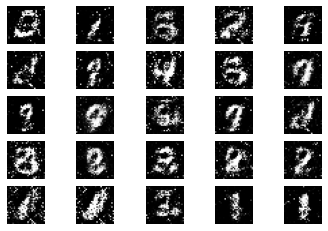

[251/400][0/16] 	Loss_D: 1.2061	Loss_G: 1.2411	D(x): 0.4615	D(G(z)): 0.0586
[252/400][0/16] 	Loss_D: 0.6585	Loss_G: 1.2854	D(x): 0.6846	D(G(z)): 0.1452
[253/400][0/16] 	Loss_D: 0.8324	Loss_G: 1.4109	D(x): 0.5813	D(G(z)): 0.1157
[254/400][0/16] 	Loss_D: 1.0319	Loss_G: 1.1692	D(x): 0.4888	D(G(z)): 0.0805
[255/400][0/16] 	Loss_D: 0.6900	Loss_G: 1.8140	D(x): 0.7571	D(G(z)): 0.2759
[256/400][0/16] 	Loss_D: 0.6484	Loss_G: 1.5417	D(x): 0.7132	D(G(z)): 0.1848
[257/400][0/16] 	Loss_D: 0.5872	Loss_G: 2.3481	D(x): 0.8063	D(G(z)): 0.2527
[258/400][0/16] 	Loss_D: 0.5967	Loss_G: 1.3645	D(x): 0.7786	D(G(z)): 0.2198
[259/400][0/16] 	Loss_D: 0.7339	Loss_G: 1.1475	D(x): 0.6596	D(G(z)): 0.1730
[260/400][0/16] 	Loss_D: 0.7394	Loss_G: 1.3581	D(x): 0.6735	D(G(z)): 0.1748
[261/400][0/16] 	Loss_D: 1.0483	Loss_G: 2.4742	D(x): 0.8698	D(G(z)): 0.5107
[262/400][0/16] 	Loss_D: 0.6319	Loss_G: 2.0666	D(x): 0.8289	D(G(z)): 0.3164
[263/400][0/16] 	Loss_D: 0.6160	Loss_G: 1.8430	D(x): 0.7776	D(G(z)): 0.2532
[264/400][0/

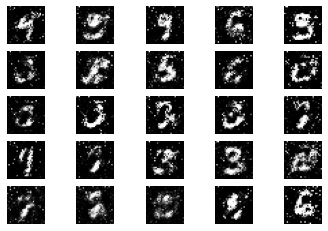

[276/400][0/16] 	Loss_D: 0.6057	Loss_G: 2.8467	D(x): 0.8824	D(G(z)): 0.3462
[277/400][0/16] 	Loss_D: 0.6779	Loss_G: 2.6225	D(x): 0.8635	D(G(z)): 0.3610
[278/400][0/16] 	Loss_D: 0.6911	Loss_G: 1.8021	D(x): 0.7695	D(G(z)): 0.3007
[279/400][0/16] 	Loss_D: 0.7622	Loss_G: 2.6287	D(x): 0.8314	D(G(z)): 0.3922
[280/400][0/16] 	Loss_D: 0.7655	Loss_G: 2.2515	D(x): 0.8113	D(G(z)): 0.3681
[281/400][0/16] 	Loss_D: 0.6245	Loss_G: 1.6867	D(x): 0.7252	D(G(z)): 0.1714
[282/400][0/16] 	Loss_D: 0.9873	Loss_G: 0.9983	D(x): 0.5112	D(G(z)): 0.0524
[283/400][0/16] 	Loss_D: 0.6798	Loss_G: 1.4803	D(x): 0.6737	D(G(z)): 0.1459
[284/400][0/16] 	Loss_D: 0.5113	Loss_G: 2.2298	D(x): 0.8359	D(G(z)): 0.2470
[285/400][0/16] 	Loss_D: 0.6737	Loss_G: 3.1246	D(x): 0.8627	D(G(z)): 0.3615
[286/400][0/16] 	Loss_D: 0.6879	Loss_G: 2.5464	D(x): 0.8551	D(G(z)): 0.3630
[287/400][0/16] 	Loss_D: 0.7587	Loss_G: 2.3109	D(x): 0.8633	D(G(z)): 0.4097
[288/400][0/16] 	Loss_D: 0.5597	Loss_G: 1.6841	D(x): 0.7797	D(G(z)): 0.2062
[289/400][0/

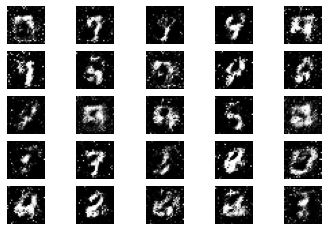

[301/400][0/16] 	Loss_D: 0.8207	Loss_G: 1.3909	D(x): 0.7048	D(G(z)): 0.2892
[302/400][0/16] 	Loss_D: 0.7110	Loss_G: 2.3329	D(x): 0.8166	D(G(z)): 0.3586
[303/400][0/16] 	Loss_D: 0.6946	Loss_G: 1.4635	D(x): 0.7215	D(G(z)): 0.2478
[304/400][0/16] 	Loss_D: 0.9561	Loss_G: 0.7776	D(x): 0.5168	D(G(z)): 0.1091
[305/400][0/16] 	Loss_D: 0.7495	Loss_G: 1.7283	D(x): 0.6660	D(G(z)): 0.1731
[306/400][0/16] 	Loss_D: 0.5417	Loss_G: 1.9247	D(x): 0.7529	D(G(z)): 0.1768
[307/400][0/16] 	Loss_D: 0.6162	Loss_G: 1.5998	D(x): 0.7293	D(G(z)): 0.2027
[308/400][0/16] 	Loss_D: 0.7960	Loss_G: 1.1386	D(x): 0.5904	D(G(z)): 0.0938
[309/400][0/16] 	Loss_D: 0.7376	Loss_G: 1.8481	D(x): 0.7286	D(G(z)): 0.2717
[310/400][0/16] 	Loss_D: 0.6223	Loss_G: 1.5534	D(x): 0.7775	D(G(z)): 0.2531
[311/400][0/16] 	Loss_D: 0.6591	Loss_G: 2.1245	D(x): 0.8114	D(G(z)): 0.3165
[312/400][0/16] 	Loss_D: 0.8307	Loss_G: 2.3163	D(x): 0.8879	D(G(z)): 0.4423
[313/400][0/16] 	Loss_D: 0.8340	Loss_G: 1.2089	D(x): 0.5875	D(G(z)): 0.1037
[314/400][0/

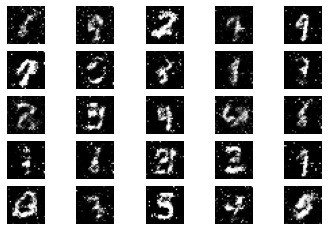

[326/400][0/16] 	Loss_D: 0.7506	Loss_G: 2.3710	D(x): 0.7986	D(G(z)): 0.3388
[327/400][0/16] 	Loss_D: 0.7630	Loss_G: 2.0734	D(x): 0.7656	D(G(z)): 0.3361
[328/400][0/16] 	Loss_D: 0.9739	Loss_G: 3.2273	D(x): 0.9102	D(G(z)): 0.5056
[329/400][0/16] 	Loss_D: 0.9843	Loss_G: 2.8543	D(x): 0.8896	D(G(z)): 0.5162
[330/400][0/16] 	Loss_D: 0.5862	Loss_G: 1.7613	D(x): 0.8140	D(G(z)): 0.2495
[331/400][0/16] 	Loss_D: 0.9338	Loss_G: 3.4551	D(x): 0.9145	D(G(z)): 0.5326
[332/400][0/16] 	Loss_D: 0.8969	Loss_G: 2.8321	D(x): 0.8591	D(G(z)): 0.4773
[333/400][0/16] 	Loss_D: 0.7119	Loss_G: 1.9698	D(x): 0.7641	D(G(z)): 0.2999
[334/400][0/16] 	Loss_D: 0.7110	Loss_G: 1.4839	D(x): 0.7650	D(G(z)): 0.2977
[335/400][0/16] 	Loss_D: 0.7602	Loss_G: 1.0908	D(x): 0.6614	D(G(z)): 0.2243
[336/400][0/16] 	Loss_D: 0.7315	Loss_G: 1.9462	D(x): 0.7721	D(G(z)): 0.3096
[337/400][0/16] 	Loss_D: 1.5278	Loss_G: 3.5084	D(x): 0.9702	D(G(z)): 0.7191
[338/400][0/16] 	Loss_D: 1.0665	Loss_G: 2.5872	D(x): 0.8836	D(G(z)): 0.5427
[339/400][0/

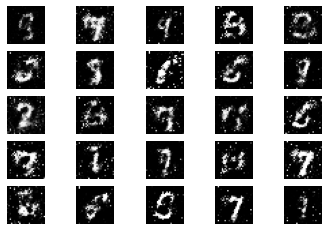

[351/400][0/16] 	Loss_D: 0.8807	Loss_G: 1.2080	D(x): 0.5921	D(G(z)): 0.1644
[352/400][0/16] 	Loss_D: 0.7377	Loss_G: 1.2386	D(x): 0.6686	D(G(z)): 0.1962
[353/400][0/16] 	Loss_D: 0.7748	Loss_G: 1.4250	D(x): 0.6760	D(G(z)): 0.2456
[354/400][0/16] 	Loss_D: 0.6644	Loss_G: 1.7514	D(x): 0.7158	D(G(z)): 0.2239
[355/400][0/16] 	Loss_D: 0.7862	Loss_G: 2.1496	D(x): 0.8115	D(G(z)): 0.3837
[356/400][0/16] 	Loss_D: 0.7852	Loss_G: 1.4231	D(x): 0.6357	D(G(z)): 0.1794
[357/400][0/16] 	Loss_D: 0.7905	Loss_G: 1.7084	D(x): 0.7330	D(G(z)): 0.3183
[358/400][0/16] 	Loss_D: 0.8235	Loss_G: 1.5684	D(x): 0.7504	D(G(z)): 0.3499
[359/400][0/16] 	Loss_D: 1.0474	Loss_G: 0.8745	D(x): 0.4716	D(G(z)): 0.0711
[360/400][0/16] 	Loss_D: 0.7251	Loss_G: 2.3710	D(x): 0.7998	D(G(z)): 0.3458
[361/400][0/16] 	Loss_D: 0.9327	Loss_G: 0.9584	D(x): 0.5670	D(G(z)): 0.1703
[362/400][0/16] 	Loss_D: 0.8703	Loss_G: 2.3065	D(x): 0.8474	D(G(z)): 0.4491
[363/400][0/16] 	Loss_D: 0.7163	Loss_G: 1.6521	D(x): 0.6801	D(G(z)): 0.2039
[364/400][0/

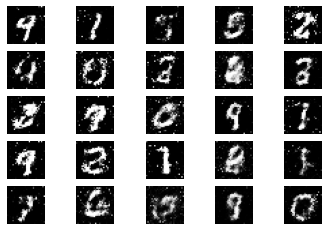

[376/400][0/16] 	Loss_D: 0.8666	Loss_G: 1.1044	D(x): 0.5747	D(G(z)): 0.1722
[377/400][0/16] 	Loss_D: 0.7172	Loss_G: 1.3691	D(x): 0.7016	D(G(z)): 0.2388
[378/400][0/16] 	Loss_D: 0.7239	Loss_G: 2.1130	D(x): 0.7592	D(G(z)): 0.2909
[379/400][0/16] 	Loss_D: 0.9103	Loss_G: 2.2697	D(x): 0.8426	D(G(z)): 0.4638
[380/400][0/16] 	Loss_D: 0.8208	Loss_G: 1.8652	D(x): 0.7888	D(G(z)): 0.3855
[381/400][0/16] 	Loss_D: 0.7569	Loss_G: 1.8131	D(x): 0.7609	D(G(z)): 0.3048
[382/400][0/16] 	Loss_D: 0.9399	Loss_G: 2.0735	D(x): 0.8647	D(G(z)): 0.4889
[383/400][0/16] 	Loss_D: 0.9385	Loss_G: 0.9372	D(x): 0.5339	D(G(z)): 0.1604
[384/400][0/16] 	Loss_D: 0.8401	Loss_G: 1.4648	D(x): 0.5738	D(G(z)): 0.1376
[385/400][0/16] 	Loss_D: 0.7309	Loss_G: 1.7432	D(x): 0.7731	D(G(z)): 0.3245
[386/400][0/16] 	Loss_D: 0.9567	Loss_G: 2.4112	D(x): 0.8859	D(G(z)): 0.5175
[387/400][0/16] 	Loss_D: 0.8700	Loss_G: 1.4354	D(x): 0.6291	D(G(z)): 0.2520
[388/400][0/16] 	Loss_D: 1.1609	Loss_G: 0.7787	D(x): 0.4354	D(G(z)): 0.1159
[389/400][0/

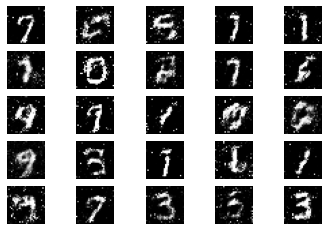

In [25]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []


sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device)
      true_labels = torch.ones(true_imgs.shape[0], dtype=torch.float, device=device) # FILL IN HERE. CAREFUL, WE WANT A 1-DIMENSIONAL TENSOR OF LABELS (DUE TO THE "VIEW" IN NEXT LINE)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs).view(-1) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(true_imgs.shape[0], 1, 1,10, device=device) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)  # FILL IN HERE
      fake_labels = torch.zeros(fake_imgs.shape[0], dtype=torch.float, device=device) # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()).view(-1)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)  # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs).view(-1) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())


  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


Hopefully, you have managed to get the GAN working. Yoohoo !! You should notice that the results are much less smooth than those of the variational autoencoder. This is normal, in general a GAN produces sharper results, but is quite difficult to get working well. You can try and modify the latent space to see whether this improves the results.

# Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [11]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Files already downloaded and verified


Now, we can redefine the hyper-parameters of the model (change if you wish)

In [12]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [13]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim=10, h_dim_1=1024, n_channels_1=64, n_channels_2=16, n_channels_3=16,n_rows=32,n_cols=32,n_channels_out=3):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels_out = n_channels_out
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim
    self.h_dim_1=h_dim_1
    self.n_channels_1= n_channels_1
    self.n_channels_2 = n_channels_2
    self.n_channels_3 = n_channels_3

    self.fc1 = nn.Linear(z_dim, h_dim_1)
    self.conv1 = nn.Conv2d(n_channels_1,n_channels_2,kernel_size=(3,3),padding=(1,1))
    self.conv2 = nn.Conv2d(n_channels_2,n_channels_3,kernel_size=(3,3),padding=(1,1))
    self.conv3 = nn.Conv2d(n_channels_3, n_channels_out,kernel_size=(3,3),padding=(1,1))
  def forward(self, z):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(z)).view(-1,self.n_channels_1,4,4)
    # input shape : 4 x 4 x 64
    y = nn.LeakyReLU(negative_slope=0.2)(self.conv1(y))
    y = nn.Upsample(scale_factor=2, mode='bilinear')(y)
    # input shape : 8 x 8 x 16
    y = nn.LeakyReLU(negative_slope=0.2)(self.conv2(y))
    y = nn.Upsample(scale_factor=2, mode='bilinear')( y )
    # input shape : 16 x 16 x 16
    y = nn.LeakyReLU(negative_slope=0.2)(self.conv3(y))
    y = nn.Upsample(scale_factor=2, mode='bilinear')( y )
    # input shape : 32 x 32 x 3
    y = y.view(-1,self.n_channels_out,self.n_rows,self.n_cols)

    return(y)


class Discriminator(nn.Module):
  def __init__(self, n_channels_3=16, n_channels_2=16, n_channels_1=64, h_dim_1=1024, z_dim=10,n_rows=32,n_cols=32,n_channels_in=3):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels_in = n_channels_in
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim
    self.h_dim_1=h_dim_1
    self.n_channels_1= n_channels_1
    self.n_channels_2 = n_channels_2
    self.n_channels_3 = n_channels_3

    self.conv1 = nn.Conv2d(self.n_channels_in,self.n_channels_3,kernel_size=(2,2),stride=(2,2))
    self.conv2 = nn.Conv2d(self.n_channels_3,self.n_channels_2,kernel_size=(2,2),stride=(2,2))
    self.conv3 = nn.Conv2d(self.n_channels_2, self.n_channels_1,kernel_size=(2,2),stride=(2,2))
    self.fc1 = nn.Linear(self.h_dim_1,1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.conv1(x))
    # input shape : 16 x 16 x 16
    y = nn.LeakyReLU(negative_slope=0.2)(self.conv2(y))
    # input shape : 8 x 8 x 16
    y = nn.LeakyReLU(negative_slope=0.2)(self.conv3(y))
    # input shape : 4 x 4 x 64
    #flatten
    y = y.view(-1,self.h_dim_1)
    y = self.fc1(y)
    y = nn.Sigmoid()(y)
    return y


gen_model = Generator(z_dim=z_dim, h_dim_1=1024, n_channels_1=64, n_channels_2=16, n_channels_3=16,n_rows=n_rows,n_cols=n_cols,n_channels_out=n_channels).to(device)
# Print the model
print(gen_model)

disc_model = Discriminator(n_channels_3=16, n_channels_2=16, n_channels_1=64, h_dim_1=1024, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels_in=n_channels).to(device)
# Print the model
print(disc_model)
  
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

bce_criterion = nn.BCELoss()


Generator(
  (fc1): Linear(in_features=10, out_features=1024, bias=True)
  (conv1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=1024, out_features=1, bias=True)
)


Now, carry out the training (use code above)

Starting Training
[0/300][0/32] 	Loss_D: 1.3866	Loss_G: 0.6922	D(x): 0.5003	D(G(z)): 0.5004


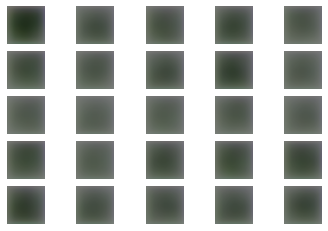

[1/300][0/32] 	Loss_D: 1.3456	Loss_G: 0.6813	D(x): 0.5357	D(G(z)): 0.5130
[2/300][0/32] 	Loss_D: 1.1964	Loss_G: 0.7748	D(x): 0.5776	D(G(z)): 0.4650
[3/300][0/32] 	Loss_D: 0.9955	Loss_G: 1.0325	D(x): 0.6284	D(G(z)): 0.3978
[4/300][0/32] 	Loss_D: 1.1807	Loss_G: 0.6601	D(x): 0.7268	D(G(z)): 0.5472
[5/300][0/32] 	Loss_D: 1.1294	Loss_G: 1.6346	D(x): 0.4099	D(G(z)): 0.1972
[6/300][0/32] 	Loss_D: 0.9739	Loss_G: 1.0799	D(x): 0.5853	D(G(z)): 0.3388
[7/300][0/32] 	Loss_D: 1.1763	Loss_G: 0.6163	D(x): 0.7095	D(G(z)): 0.5569
[8/300][0/32] 	Loss_D: 0.7597	Loss_G: 1.1897	D(x): 0.7129	D(G(z)): 0.3078
[9/300][0/32] 	Loss_D: 1.0401	Loss_G: 1.6778	D(x): 0.4662	D(G(z)): 0.2034
[10/300][0/32] 	Loss_D: 1.0543	Loss_G: 1.0484	D(x): 0.5609	D(G(z)): 0.3518
[11/300][0/32] 	Loss_D: 0.9902	Loss_G: 1.0683	D(x): 0.6322	D(G(z)): 0.3557
[12/300][0/32] 	Loss_D: 0.9463	Loss_G: 1.1286	D(x): 0.6461	D(G(z)): 0.3354
[13/300][0/32] 	Loss_D: 0.8724	Loss_G: 1.0303	D(x): 0.7092	D(G(z)): 0.3695
[14/300][0/32] 	Loss_D: 0.6483	Los

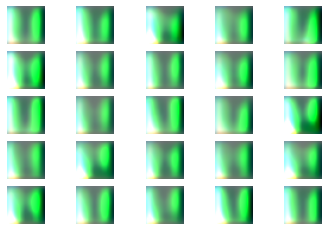

[26/300][0/32] 	Loss_D: 1.1575	Loss_G: 1.1786	D(x): 0.5892	D(G(z)): 0.3632
[27/300][0/32] 	Loss_D: 0.8295	Loss_G: 1.0503	D(x): 0.7719	D(G(z)): 0.3768
[28/300][0/32] 	Loss_D: 0.6134	Loss_G: 1.4907	D(x): 0.7808	D(G(z)): 0.2483
[29/300][0/32] 	Loss_D: 0.8140	Loss_G: 1.7756	D(x): 0.6270	D(G(z)): 0.1943
[30/300][0/32] 	Loss_D: 1.1717	Loss_G: 1.3416	D(x): 0.5611	D(G(z)): 0.3240
[31/300][0/32] 	Loss_D: 0.8279	Loss_G: 1.5018	D(x): 0.6706	D(G(z)): 0.2454
[32/300][0/32] 	Loss_D: 0.7785	Loss_G: 1.5473	D(x): 0.6912	D(G(z)): 0.2372
[33/300][0/32] 	Loss_D: 1.0943	Loss_G: 1.4652	D(x): 0.6575	D(G(z)): 0.2857
[34/300][0/32] 	Loss_D: 1.0762	Loss_G: 1.9255	D(x): 0.5672	D(G(z)): 0.1913
[35/300][0/32] 	Loss_D: 1.0114	Loss_G: 1.0725	D(x): 0.6992	D(G(z)): 0.4144
[36/300][0/32] 	Loss_D: 1.0526	Loss_G: 1.0436	D(x): 0.6850	D(G(z)): 0.4009
[37/300][0/32] 	Loss_D: 1.0687	Loss_G: 1.1711	D(x): 0.6660	D(G(z)): 0.3783
[38/300][0/32] 	Loss_D: 1.2529	Loss_G: 1.8753	D(x): 0.5389	D(G(z)): 0.2382
[39/300][0/32] 	Loss_D: 0

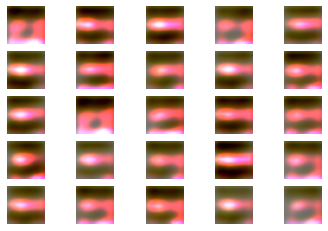

[51/300][0/32] 	Loss_D: 1.4053	Loss_G: 1.2427	D(x): 0.4594	D(G(z)): 0.3474
[52/300][0/32] 	Loss_D: 1.3898	Loss_G: 0.9833	D(x): 0.5833	D(G(z)): 0.4494
[53/300][0/32] 	Loss_D: 1.1872	Loss_G: 1.0703	D(x): 0.5419	D(G(z)): 0.3749
[54/300][0/32] 	Loss_D: 1.1076	Loss_G: 1.2449	D(x): 0.5239	D(G(z)): 0.3255
[55/300][0/32] 	Loss_D: 0.8781	Loss_G: 1.3321	D(x): 0.6313	D(G(z)): 0.3109
[56/300][0/32] 	Loss_D: 1.5270	Loss_G: 0.7317	D(x): 0.4903	D(G(z)): 0.5260
[57/300][0/32] 	Loss_D: 1.2500	Loss_G: 0.8663	D(x): 0.5310	D(G(z)): 0.4389
[58/300][0/32] 	Loss_D: 1.1682	Loss_G: 0.9203	D(x): 0.5506	D(G(z)): 0.4122
[59/300][0/32] 	Loss_D: 1.1159	Loss_G: 0.8674	D(x): 0.5936	D(G(z)): 0.4250
[60/300][0/32] 	Loss_D: 1.2177	Loss_G: 0.7222	D(x): 0.6381	D(G(z)): 0.5049
[61/300][0/32] 	Loss_D: 1.5128	Loss_G: 0.7101	D(x): 0.4884	D(G(z)): 0.5139
[62/300][0/32] 	Loss_D: 0.9974	Loss_G: 1.1281	D(x): 0.5723	D(G(z)): 0.3347
[63/300][0/32] 	Loss_D: 0.8932	Loss_G: 1.1636	D(x): 0.6218	D(G(z)): 0.3254
[64/300][0/32] 	Loss_D: 0

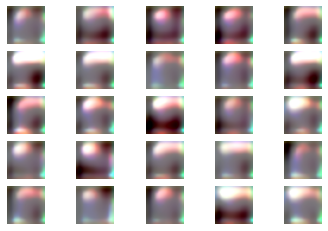

[76/300][0/32] 	Loss_D: 0.8998	Loss_G: 1.0240	D(x): 0.6836	D(G(z)): 0.3783
[77/300][0/32] 	Loss_D: 0.8665	Loss_G: 1.1635	D(x): 0.6890	D(G(z)): 0.3436
[78/300][0/32] 	Loss_D: 0.9268	Loss_G: 1.2035	D(x): 0.6448	D(G(z)): 0.3330
[79/300][0/32] 	Loss_D: 1.3046	Loss_G: 0.8878	D(x): 0.5680	D(G(z)): 0.4458
[80/300][0/32] 	Loss_D: 1.3286	Loss_G: 0.8599	D(x): 0.5590	D(G(z)): 0.4624
[81/300][0/32] 	Loss_D: 1.0091	Loss_G: 1.0866	D(x): 0.5860	D(G(z)): 0.3563
[82/300][0/32] 	Loss_D: 1.0230	Loss_G: 0.9801	D(x): 0.6301	D(G(z)): 0.3907
[83/300][0/32] 	Loss_D: 1.1236	Loss_G: 1.0095	D(x): 0.5684	D(G(z)): 0.3776
[84/300][0/32] 	Loss_D: 1.1389	Loss_G: 1.0481	D(x): 0.5990	D(G(z)): 0.4006
[85/300][0/32] 	Loss_D: 0.9363	Loss_G: 1.3202	D(x): 0.5990	D(G(z)): 0.3058
[86/300][0/32] 	Loss_D: 0.6716	Loss_G: 1.2967	D(x): 0.7396	D(G(z)): 0.2874
[87/300][0/32] 	Loss_D: 0.7416	Loss_G: 1.2988	D(x): 0.7195	D(G(z)): 0.3077
[88/300][0/32] 	Loss_D: 0.9802	Loss_G: 1.1309	D(x): 0.6889	D(G(z)): 0.3907
[89/300][0/32] 	Loss_D: 1

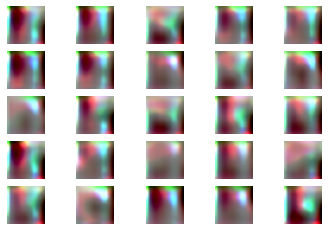

[101/300][0/32] 	Loss_D: 0.4889	Loss_G: 1.9381	D(x): 0.7896	D(G(z)): 0.1703
[102/300][0/32] 	Loss_D: 0.5694	Loss_G: 1.7578	D(x): 0.7866	D(G(z)): 0.2202
[103/300][0/32] 	Loss_D: 0.6809	Loss_G: 1.5424	D(x): 0.7467	D(G(z)): 0.2504
[104/300][0/32] 	Loss_D: 0.5332	Loss_G: 1.6198	D(x): 0.8098	D(G(z)): 0.2406
[105/300][0/32] 	Loss_D: 0.5308	Loss_G: 1.6686	D(x): 0.7875	D(G(z)): 0.1924
[106/300][0/32] 	Loss_D: 0.3879	Loss_G: 2.0309	D(x): 0.8507	D(G(z)): 0.1702
[107/300][0/32] 	Loss_D: 0.5806	Loss_G: 1.7331	D(x): 0.7887	D(G(z)): 0.2281
[108/300][0/32] 	Loss_D: 0.7346	Loss_G: 1.5856	D(x): 0.7754	D(G(z)): 0.3337
[109/300][0/32] 	Loss_D: 0.4119	Loss_G: 2.0782	D(x): 0.8172	D(G(z)): 0.1434
[110/300][0/32] 	Loss_D: 0.6156	Loss_G: 1.9191	D(x): 0.7439	D(G(z)): 0.1354
[111/300][0/32] 	Loss_D: 0.3656	Loss_G: 2.1541	D(x): 0.8414	D(G(z)): 0.1044
[112/300][0/32] 	Loss_D: 0.4350	Loss_G: 2.1282	D(x): 0.7943	D(G(z)): 0.1176
[113/300][0/32] 	Loss_D: 0.5040	Loss_G: 2.0380	D(x): 0.7790	D(G(z)): 0.1381
[114/300][0/

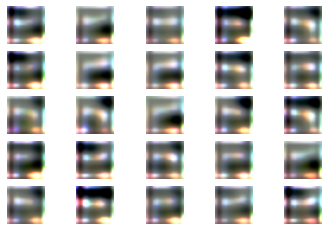

[126/300][0/32] 	Loss_D: 0.4639	Loss_G: 1.8248	D(x): 0.8085	D(G(z)): 0.1876
[127/300][0/32] 	Loss_D: 0.3446	Loss_G: 2.1277	D(x): 0.8847	D(G(z)): 0.1500
[128/300][0/32] 	Loss_D: 0.3388	Loss_G: 2.4065	D(x): 0.8669	D(G(z)): 0.1150
[129/300][0/32] 	Loss_D: 0.4384	Loss_G: 2.0743	D(x): 0.8591	D(G(z)): 0.1605
[130/300][0/32] 	Loss_D: 0.3637	Loss_G: 2.3167	D(x): 0.8465	D(G(z)): 0.1464
[131/300][0/32] 	Loss_D: 0.5024	Loss_G: 2.0201	D(x): 0.7966	D(G(z)): 0.1295
[132/300][0/32] 	Loss_D: 0.6208	Loss_G: 2.0126	D(x): 0.7516	D(G(z)): 0.1338
[133/300][0/32] 	Loss_D: 0.5200	Loss_G: 1.9820	D(x): 0.7786	D(G(z)): 0.1284
[134/300][0/32] 	Loss_D: 0.7906	Loss_G: 1.7320	D(x): 0.6937	D(G(z)): 0.2165
[135/300][0/32] 	Loss_D: 0.4622	Loss_G: 1.9251	D(x): 0.8209	D(G(z)): 0.1726
[136/300][0/32] 	Loss_D: 0.4117	Loss_G: 2.2618	D(x): 0.8188	D(G(z)): 0.1112
[137/300][0/32] 	Loss_D: 0.2396	Loss_G: 2.4541	D(x): 0.9059	D(G(z)): 0.1091
[138/300][0/32] 	Loss_D: 0.1919	Loss_G: 2.5550	D(x): 0.9398	D(G(z)): 0.1109
[139/300][0/

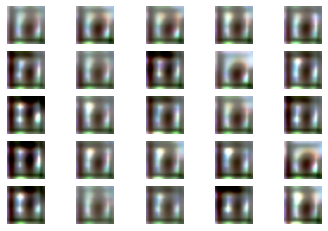

[151/300][0/32] 	Loss_D: 0.2758	Loss_G: 2.2213	D(x): 0.9036	D(G(z)): 0.1345
[152/300][0/32] 	Loss_D: 0.2067	Loss_G: 2.5554	D(x): 0.9154	D(G(z)): 0.0822
[153/300][0/32] 	Loss_D: 0.2196	Loss_G: 2.4787	D(x): 0.9428	D(G(z)): 0.1392
[154/300][0/32] 	Loss_D: 0.1997	Loss_G: 2.7228	D(x): 0.9410	D(G(z)): 0.1159
[155/300][0/32] 	Loss_D: 0.3363	Loss_G: 2.4850	D(x): 0.8355	D(G(z)): 0.0623
[156/300][0/32] 	Loss_D: 0.3182	Loss_G: 2.2329	D(x): 0.9129	D(G(z)): 0.1624
[157/300][0/32] 	Loss_D: 0.2055	Loss_G: 2.7805	D(x): 0.9134	D(G(z)): 0.0788
[158/300][0/32] 	Loss_D: 0.1467	Loss_G: 3.0766	D(x): 0.9244	D(G(z)): 0.0489
[159/300][0/32] 	Loss_D: 0.1616	Loss_G: 2.7677	D(x): 0.9367	D(G(z)): 0.0720
[160/300][0/32] 	Loss_D: 0.3135	Loss_G: 2.1593	D(x): 0.8908	D(G(z)): 0.1209
[161/300][0/32] 	Loss_D: 0.2524	Loss_G: 2.8084	D(x): 0.8857	D(G(z)): 0.0594
[162/300][0/32] 	Loss_D: 0.2854	Loss_G: 2.8421	D(x): 0.9130	D(G(z)): 0.0824
[163/300][0/32] 	Loss_D: 0.4569	Loss_G: 2.3354	D(x): 0.9037	D(G(z)): 0.1907
[164/300][0/

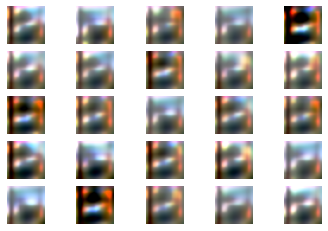

[176/300][0/32] 	Loss_D: 0.4270	Loss_G: 2.3802	D(x): 0.9597	D(G(z)): 0.2939
[177/300][0/32] 	Loss_D: 0.3036	Loss_G: 2.6262	D(x): 0.8571	D(G(z)): 0.0712
[178/300][0/32] 	Loss_D: 0.2878	Loss_G: 3.0731	D(x): 0.9100	D(G(z)): 0.0940
[179/300][0/32] 	Loss_D: 0.2496	Loss_G: 2.7360	D(x): 0.8882	D(G(z)): 0.0603
[180/300][0/32] 	Loss_D: 0.1936	Loss_G: 2.7201	D(x): 0.9396	D(G(z)): 0.1032
[181/300][0/32] 	Loss_D: 0.2545	Loss_G: 3.0204	D(x): 0.8865	D(G(z)): 0.0411
[182/300][0/32] 	Loss_D: 0.1383	Loss_G: 2.8184	D(x): 0.9674	D(G(z)): 0.0930
[183/300][0/32] 	Loss_D: 0.2743	Loss_G: 2.8499	D(x): 0.9176	D(G(z)): 0.0704
[184/300][0/32] 	Loss_D: 0.1408	Loss_G: 2.9820	D(x): 0.9454	D(G(z)): 0.0544
[185/300][0/32] 	Loss_D: 0.1209	Loss_G: 3.2496	D(x): 0.9549	D(G(z)): 0.0595
[186/300][0/32] 	Loss_D: 0.1917	Loss_G: 2.9396	D(x): 0.9455	D(G(z)): 0.1003
[187/300][0/32] 	Loss_D: 0.2035	Loss_G: 2.7673	D(x): 0.9472	D(G(z)): 0.1058
[188/300][0/32] 	Loss_D: 0.2430	Loss_G: 2.9170	D(x): 0.9178	D(G(z)): 0.0673
[189/300][0/

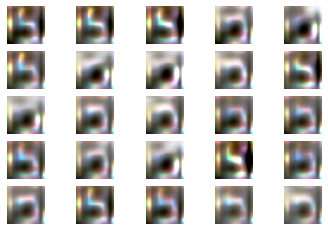

[201/300][0/32] 	Loss_D: 0.2569	Loss_G: 2.5739	D(x): 0.8823	D(G(z)): 0.0472
[202/300][0/32] 	Loss_D: 0.2381	Loss_G: 2.9345	D(x): 0.8871	D(G(z)): 0.0407
[203/300][0/32] 	Loss_D: 0.0870	Loss_G: 3.3714	D(x): 0.9616	D(G(z)): 0.0381
[204/300][0/32] 	Loss_D: 0.0953	Loss_G: 3.4861	D(x): 0.9637	D(G(z)): 0.0365
[205/300][0/32] 	Loss_D: 0.1327	Loss_G: 2.6697	D(x): 0.9707	D(G(z)): 0.0876
[206/300][0/32] 	Loss_D: 0.1602	Loss_G: 3.1157	D(x): 0.9388	D(G(z)): 0.0541
[207/300][0/32] 	Loss_D: 0.1581	Loss_G: 3.2823	D(x): 0.9553	D(G(z)): 0.0897
[208/300][0/32] 	Loss_D: 0.0879	Loss_G: 3.9887	D(x): 0.9447	D(G(z)): 0.0215
[209/300][0/32] 	Loss_D: 0.0971	Loss_G: 3.6175	D(x): 0.9490	D(G(z)): 0.0309
[210/300][0/32] 	Loss_D: 0.0626	Loss_G: 3.6652	D(x): 0.9828	D(G(z)): 0.0428
[211/300][0/32] 	Loss_D: 0.1770	Loss_G: 3.5014	D(x): 0.9040	D(G(z)): 0.0225
[212/300][0/32] 	Loss_D: 0.1162	Loss_G: 2.8821	D(x): 0.9693	D(G(z)): 0.0754
[213/300][0/32] 	Loss_D: 0.1122	Loss_G: 3.4335	D(x): 0.9488	D(G(z)): 0.0383
[214/300][0/

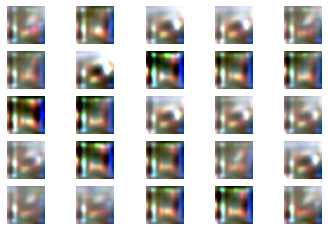

[226/300][0/32] 	Loss_D: 0.0633	Loss_G: 4.0702	D(x): 0.9710	D(G(z)): 0.0280
[227/300][0/32] 	Loss_D: 0.0639	Loss_G: 3.9698	D(x): 0.9749	D(G(z)): 0.0331
[228/300][0/32] 	Loss_D: 0.0573	Loss_G: 4.1227	D(x): 0.9757	D(G(z)): 0.0270
[229/300][0/32] 	Loss_D: 0.1516	Loss_G: 3.3871	D(x): 0.9357	D(G(z)): 0.0435
[230/300][0/32] 	Loss_D: 0.1183	Loss_G: 3.5543	D(x): 0.9547	D(G(z)): 0.0548
[231/300][0/32] 	Loss_D: 0.0881	Loss_G: 3.4954	D(x): 0.9809	D(G(z)): 0.0637
[232/300][0/32] 	Loss_D: 0.2336	Loss_G: 3.0467	D(x): 0.8985	D(G(z)): 0.0330
[233/300][0/32] 	Loss_D: 0.1494	Loss_G: 3.2782	D(x): 0.9754	D(G(z)): 0.1079
[234/300][0/32] 	Loss_D: 0.2738	Loss_G: 3.4909	D(x): 0.9557	D(G(z)): 0.1821
[235/300][0/32] 	Loss_D: 0.1976	Loss_G: 2.8645	D(x): 0.9287	D(G(z)): 0.0577
[236/300][0/32] 	Loss_D: 0.1331	Loss_G: 3.5148	D(x): 0.9351	D(G(z)): 0.0366
[237/300][0/32] 	Loss_D: 0.0785	Loss_G: 3.4124	D(x): 0.9797	D(G(z)): 0.0533
[238/300][0/32] 	Loss_D: 0.0870	Loss_G: 4.3370	D(x): 0.9552	D(G(z)): 0.0167
[239/300][0/

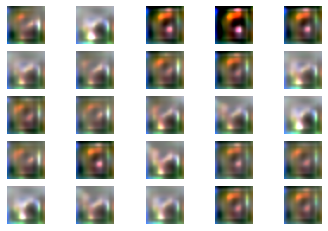

[251/300][0/32] 	Loss_D: 0.0716	Loss_G: 3.7659	D(x): 0.9745	D(G(z)): 0.0393
[252/300][0/32] 	Loss_D: 0.1561	Loss_G: 4.0666	D(x): 0.9744	D(G(z)): 0.1005
[253/300][0/32] 	Loss_D: 0.0786	Loss_G: 4.0438	D(x): 0.9681	D(G(z)): 0.0361
[254/300][0/32] 	Loss_D: 0.1463	Loss_G: 3.5773	D(x): 0.9718	D(G(z)): 0.1012
[255/300][0/32] 	Loss_D: 0.0832	Loss_G: 3.6840	D(x): 0.9566	D(G(z)): 0.0290
[256/300][0/32] 	Loss_D: 0.0828	Loss_G: 3.8190	D(x): 0.9636	D(G(z)): 0.0316
[257/300][0/32] 	Loss_D: 0.1027	Loss_G: 3.4119	D(x): 0.9669	D(G(z)): 0.0600
[258/300][0/32] 	Loss_D: 0.1643	Loss_G: 2.8962	D(x): 0.9280	D(G(z)): 0.0465
[259/300][0/32] 	Loss_D: 0.1646	Loss_G: 2.9410	D(x): 0.9204	D(G(z)): 0.0365
[260/300][0/32] 	Loss_D: 0.1165	Loss_G: 3.7077	D(x): 0.9397	D(G(z)): 0.0330
[261/300][0/32] 	Loss_D: 0.1719	Loss_G: 2.8542	D(x): 0.9366	D(G(z)): 0.0736
[262/300][0/32] 	Loss_D: 0.2571	Loss_G: 3.1961	D(x): 0.9137	D(G(z)): 0.0443
[263/300][0/32] 	Loss_D: 0.1085	Loss_G: 3.3788	D(x): 0.9836	D(G(z)): 0.0803
[264/300][0/

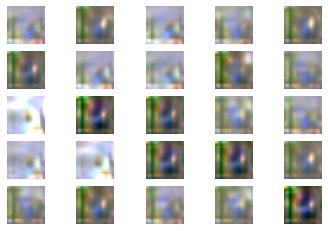

[276/300][0/32] 	Loss_D: 0.2660	Loss_G: 4.3050	D(x): 0.9964	D(G(z)): 0.1678
[277/300][0/32] 	Loss_D: 0.1392	Loss_G: 3.2914	D(x): 0.9416	D(G(z)): 0.0441
[278/300][0/32] 	Loss_D: 0.1389	Loss_G: 3.1837	D(x): 0.9777	D(G(z)): 0.0997
[279/300][0/32] 	Loss_D: 0.0685	Loss_G: 4.7721	D(x): 0.9679	D(G(z)): 0.0217
[280/300][0/32] 	Loss_D: 0.0955	Loss_G: 3.6594	D(x): 0.9541	D(G(z)): 0.0362
[281/300][0/32] 	Loss_D: 0.0522	Loss_G: 4.7007	D(x): 0.9802	D(G(z)): 0.0191
[282/300][0/32] 	Loss_D: 0.0687	Loss_G: 4.6685	D(x): 0.9712	D(G(z)): 0.0160
[283/300][0/32] 	Loss_D: 0.1398	Loss_G: 4.2426	D(x): 0.9498	D(G(z)): 0.0169
[284/300][0/32] 	Loss_D: 0.0922	Loss_G: 4.4914	D(x): 0.9624	D(G(z)): 0.0170
[285/300][0/32] 	Loss_D: 0.0767	Loss_G: 3.9409	D(x): 0.9588	D(G(z)): 0.0212
[286/300][0/32] 	Loss_D: 0.0548	Loss_G: 4.1852	D(x): 0.9850	D(G(z)): 0.0366
[287/300][0/32] 	Loss_D: 0.1963	Loss_G: 3.0036	D(x): 0.9526	D(G(z)): 0.1028
[288/300][0/32] 	Loss_D: 0.1394	Loss_G: 3.9453	D(x): 0.9441	D(G(z)): 0.0219
[289/300][0/

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []


sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(cifar_train_loader,0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device)
      true_labels = torch.ones((true_imgs.shape[0],), dtype=torch.float, device=device)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs).view(-1)
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels)
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(true_imgs.shape[0], 1, z_dim, device=device)
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)
      fake_labels = torch.zeros((fake_imgs.shape[0],), dtype=torch.float, device=device)
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()).view(-1)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs).view(-1)
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake)
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(cifar_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())


  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)